In [6]:
filenum = 4
expid = 1

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
num_epochs = 1000
batch_size = 64
learning_rate = 1e-6
num_samples = 2560


# Define alphas to try for LeakyReLU
alphas = [0, 0.05, -1, -2]

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

indices = torch.randperm(len(trainset))[:num_samples]
sampler = torch.utils.data.SubsetRandomSampler(indices)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=sampler)

indices = torch.randperm(len(testset))[:num_samples]
sampler = torch.utils.data.SubsetRandomSampler(indices)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, sampler=sampler)


Files already downloaded and verified
Files already downloaded and verified


In [8]:

# Define CNN model
class Net(nn.Module):
    def __init__(self, alpha, m):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, m, kernel_size=3, padding=1)
        nn.init.normal_(self.conv1.weight, mean=0, std=np.sqrt(1./m))
        self.conv2 = nn.Conv2d(m, m, kernel_size=3, padding=1)
        nn.init.normal_(self.conv2.weight, mean=0, std=np.sqrt(1./m))
        self.conv3 = nn.Conv2d(m, m, kernel_size=3, padding=1)
        nn.init.normal_(self.conv3.weight, mean=0, std=np.sqrt(1./m))
        self.conv4 = nn.Conv2d(m, m, kernel_size=3, padding=1)
        nn.init.normal_(self.conv4.weight, mean=0, std=np.sqrt(1./m))
        self.fc1 = nn.Linear(8*8*m, m)
        nn.init.normal_(self.fc1.weight, mean=0, std=np.sqrt(1./m))
        self.fc2 = nn.Linear(m, 10)
        nn.init.normal_(self.fc2.weight, mean=0, std=np.sqrt(1./10))
        self.relu = nn.LeakyReLU(negative_slope=alpha)
        self.alpha = alpha
        self.m = m

    def forward(self, x):
        x = self.relu(self.conv1(x))/(np.sqrt(1+self.alpha*self.alpha))
        x = self.relu(self.conv2(x))/(np.sqrt(1+self.alpha*self.alpha))
        x = nn.functional.max_pool2d(x, 2)
        x = self.relu(self.conv3(x))/(np.sqrt(1+self.alpha*self.alpha))
        x = self.relu(self.conv4(x))/(np.sqrt(1+self.alpha*self.alpha))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 8*8*self.m)
        x = self.relu(self.fc1(x))/(np.sqrt(1+self.alpha*self.alpha))
        x = self.fc2(x)
        return x

In [9]:

def train(alpha, m=512):
    net = Net(alpha, m).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0, momentum=0)

    # Train the model
    train_losses = []
    test_losses = []
    torch.manual_seed(expid)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        running_loss_train = 0.0
        running_loss_test = 0.0
        net.eval()
        with torch.no_grad():
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss_train += loss.item()
            train_losses.append((running_loss_train)/len(trainloader)/batch_size)
            print('[%d] loss: %.3f' %
                  (epoch + 1, running_loss_train))
            for i, data in enumerate(testloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss_test += loss.item()
            test_losses.append((running_loss_test)/len(testloader)/batch_size)
        net.train()
    return net, train_losses, test_losses


In [ ]:

train_losses = {}
test_losses = {}
for alpha in [0, 0.05, -1, -2]:
    print ("ALPHA = ", alpha)
    net, train_losses[alpha], test_losses[alpha] = train(alpha,512)
    

ALPHA =  0
[1] loss: 2083.302
[2] loss: 1624.512
[3] loss: 1352.501
[4] loss: 1203.118
[5] loss: 1111.429
[6] loss: 1040.837
[7] loss: 980.920
[8] loss: 934.374
[9] loss: 901.944
[10] loss: 879.327
[11] loss: 861.451
[12] loss: 845.321
[13] loss: 830.395
[14] loss: 816.544
[15] loss: 803.519
[16] loss: 791.251
[17] loss: 779.709
[18] loss: 768.757
[19] loss: 758.264
[20] loss: 748.176
[21] loss: 738.488
[22] loss: 729.203
[23] loss: 720.217
[24] loss: 711.489
[25] loss: 703.173
[26] loss: 695.062
[27] loss: 687.281
[28] loss: 679.677
[29] loss: 672.287
[30] loss: 665.240
[31] loss: 658.440
[32] loss: 651.700
[33] loss: 645.295
[34] loss: 638.952
[35] loss: 632.748
[36] loss: 626.815
[37] loss: 620.886
[38] loss: 615.138
[39] loss: 609.595
[40] loss: 604.137
[41] loss: 598.735
[42] loss: 593.600
[43] loss: 588.586
[44] loss: 583.591
[45] loss: 578.878
[46] loss: 574.050
[47] loss: 569.364
[48] loss: 564.973
[49] loss: 560.448
[50] loss: 556.249
[51] loss: 551.925
[52] loss: 547.545
[53]

In [6]:
torch.save(train_losses, 'cnn_leaky_result_train'+str(filenum).zfill(3)+'_'+str(expid).zfill(3)+'.pt')
torch.save(test_losses, 'cnn_leaky_result_test'+str(filenum).zfill(3)+'_'+str(expid).zfill(3)+'.pt')

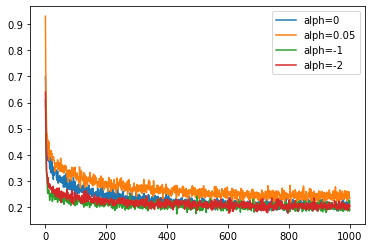

In [9]:
import matplotlib.pyplot as plt
for alpha in [0, 0.05, -1, -2]:
    plt.plot(train_losses[alpha], label=f'alph={alpha}')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')